## Dataset Link: https://www.kaggle.com/datasets/shyambhu/hands-and-palm-images-dataset/data

In [ ]:
# DOWNLOAD DATASET THROUGH KAGGLE API
from google.colab import files
files.upload()

!mkdir /root/.kaggle
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d shyambhu/hands-and-palm-images-dataset

Saving kaggle.json to kaggle.json
100% 631M/634M [00:08<00:00, 75.0MB/s]
100% 634M/634M [00:08<00:00, 75.1MB/s]


In [ ]:
!unzip /content/hands-and-palm-images-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Hands/Hands/Hand_0006508.jpg  
  inflating: Hands/Hands/Hand_0006509.jpg  
  inflating: Hands/Hands/Hand_0006510.jpg  
  inflating: Hands/Hands/Hand_0006511.jpg  
  inflating: Hands/Hands/Hand_0006512.jpg  
  inflating: Hands/Hands/Hand_0006513.jpg  
  inflating: Hands/Hands/Hand_0006514.jpg  
  inflating: Hands/Hands/Hand_0006515.jpg  
  inflating: Hands/Hands/Hand_0006516.jpg  
  inflating: Hands/Hands/Hand_0006517.jpg  
  inflating: Hands/Hands/Hand_0006518.jpg  
  inflating: Hands/Hands/Hand_0006519.jpg  
  inflating: Hands/Hands/Hand_0006520.jpg  
  inflating: Hands/Hands/Hand_0006521.jpg  
  inflating: Hands/Hands/Hand_0006522.jpg  
  inflating: Hands/Hands/Hand_0006523.jpg  
  inflating: Hands/Hands/Hand_0006524.jpg  
  inflating: Hands/Hands/Hand_0006525.jpg  
  inflating: Hands/Hands/Hand_0006526.jpg  
  inflating: Hands/Hands/Hand_0006527.jpg  
  inflating: Hands/Hands/Hand_0006528.jpg  
  inflating: Hands/Hands/

# **Making a Dataset (Cropping Images)**

In [ ]:
# improt the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
!pip install tabulate
from tabulate import tabulate
import os
import matplotlib.image as mpimg
import random
import cv2

pd.set_option('display.max_columns', None)

# Ignore warning
import warnings
warnings.filterwarnings('ignore')

# <font color='magma' size=6> **Preprocessing Steps**
________________________
* **Normalization**:Normalize the pixel intensity values of the raw image to a range of 0 to 1 using min-max normalization.
* **Resizing**:Resize the image to a predefined width and height.
* **Binarization**:
  * Convert the image to grayscale.
  * Apply a thresholding technique to create a binary image:
  * Pixels with intensity values above a certain threshold are set to 255 (white).
  * Pixels below the threshold are set to 0 (black).
  * Perform morphological operations (erosion and dilation) to remove noise from the binary image.
* **Contour Extraction**:
  * Find contours in the binary image.
  * Identify the contour with the largest area, presumably representing the hand.
* **Extreme Points Detection**:
  * Find the extreme points (leftmost, topmost, rightmost, bottommost) along the contour.
* Bounding Box Calculation:
  * Calculate the bounding box coordinates (x, y, width, height) that enclose the hand region using the extreme points.
* **Region of Interest (ROI) Extraction**:
  * Crop the region of interest (ROI) from the raw image based on the bounding box coordinates.
  * The ROI is typically the top half of the hand, calculated from the center of the bounding box.
* **Standardization**:Standardize the pixel intensity values of the cropped image to a range of 0 to 1.
* **Final Resizing**:Resize the standardized image to a predefined width and height.

In [ ]:
INPUT_IMG_DIM = (32, 64, 3)

In [ ]:
def normalize_image(raw_image):
    '''
    Normalize the pixel intensity of an image.

    Args:
    - raw_image: A numpy array representing the raw image.

    Returns:
    - normalized_image: A numpy array representing the normalized image.
    '''
    normalized_image = cv2.normalize(raw_image, None, 0, 1.0, 
                                     cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    
    return normalized_image


def resize_image(image, width=INPUT_IMG_DIM[1], height=INPUT_IMG_DIM[0]):
    '''
    Resize an image to a specified width and height.

    Args:
    - image: A numpy array representing the image.
    - width: The desired width of the image.
    - height: The desired height of the image.

    Returns:
    - resized_image: A numpy array representing the resized image.
    '''
    return cv2.resize(image, (width, height))


def binarize_image(grayscale_image):
    '''
    Convert a grayscale image to a binary image using thresholding.

    Args:
    - grayscale_image: A numpy array representing the grayscale image.

    Returns:
    - binary_image: A numpy array representing the binary image.
    '''
    _, binary_image = cv2.threshold(grayscale_image, 220, 255, 
                                    cv2.THRESH_BINARY_INV)

    # Perform erosions and dilations to denoise image
    binary_image = cv2.erode(binary_image, None, iterations=2)
    binary_image = cv2.dilate(binary_image, None, iterations=2)
    
    return binary_image


def get_extreme_points(binary_image):
    '''
    Find the extreme points (left, top, right, bottom) of a binary image contour.

    Args:
    - binary_image: A numpy array representing the binary image.

    Returns:
    - contour: The contour of the binary image.
    - extreme_points: A tuple containing the extreme points (left, top, right, bottom).
    '''
    # Extract contours from the binary image
    contours, _ = cv2.findContours(binary_image.copy(), cv2.RETR_EXTERNAL, 
                            cv2.CHAIN_APPROX_SIMPLE)
    
    # Find the largest contour
    contour = max(contours, key=cv2.contourArea)

    # Determine the most extreme points along the contour
    left = tuple(contour[contour[:, :, 0].argmin()][0]) # left most point
    top = tuple(contour[contour[:, :, 1].argmin()][0]) # top most point
    right = tuple(contour[contour[:, :, 0].argmax()][0]) # right most point
    bottom = tuple(contour[contour[:, :, 1].argmax()][0]) # bottom most point

    return contour, (left, top, right, bottom)


def get_bounding_box(extreme_points):
    '''
    Calculate the bounding box coordinates from extreme points.

    Args:
    - extreme_points: A tuple containing the extreme points (left, top, right, bottom).

    Returns:
    - bounding_box: A tuple containing the bounding box coordinates (x, y, w, h).
    '''
    left, top, right, bottom = extreme_points
    
    x = left[0]
    y = top[1]
    w = right[0] - left[0]
    h = bottom[1]
    
    return (x, y, w, h)


def region_of_interest(raw_image, bounding_box):
    '''
    Crop the region of interest from the raw image.

    Args:
    - raw_image: A numpy array representing the raw image.
    - bounding_box: A tuple containing the bounding box coordinates (x, y, w, h).

    Returns:
    - cropped_image: A numpy array representing the cropped region of interest.
    '''
    x, y, w, h = bounding_box
    
    # Calculate the center of the bounding box
    center = (x + w // 2, y + h // 2)
    
    # Crop the top half of the hand
    top_half_image = raw_image[y:center[1], x:x+w]
    
    return top_half_image


def data_preprocessing(images):
    '''
    Preprocess a list of images for age estimation.

    Args:
    - images: A list of numpy arrays representing the raw images.

    Returns:
    - preprocessed_images: A list of numpy arrays representing the preprocessed images.
    '''
    for i in range(len(images)):
        # Preprocessing steps
        raw_image = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB) # convert to RGB

        # Convert RGB image to grayscale
        grayscale_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2GRAY)

        # Convert to a binary image
        binary_image = binarize_image(grayscale_image)

        # Extract the contour and extreme points
        contour, extreme_points = get_extreme_points(binary_image)

        left, top, right, bottom = extreme_points

        bounding_box = get_bounding_box(extreme_points)

        cropped_image = region_of_interest(raw_image, bounding_box)

        # Standardize pixel intensity to a range 0-1
        normalized_image = normalize_image(cropped_image)

        # resize the image to 200 x 300 pixels
        resized_image = resize_image(normalized_image)
        
        images[i] = resized_image
        
    return images

In [ ]:
def crop_and_save_image(img_filepath, extreme_points, output_path):
    # Load image
    raw_image = cv2.imread(img_filepath)
    raw_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)

    bounding_box = get_bounding_box(extreme_points)

    cropped_image = region_of_interest(raw_image, bounding_box)

    # Standardize pixel intensity to a range 0-1
    normalized_image = normalize_image(cropped_image)

    plt.close()

    # Save just the 'Region of interest' image without any axes or titles
    fig2 = plt.figure()
    axs2 = fig2.add_subplot(111)
    axs2.imshow(normalized_image)
    axs2.axis('off')  # Hide the axis
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)  # Remove any padding

    # Save the figure
    fig2.savefig(output_path, bbox_inches='tight', pad_inches=0)

    # Close the figure to avoid display
    plt.close(fig2)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

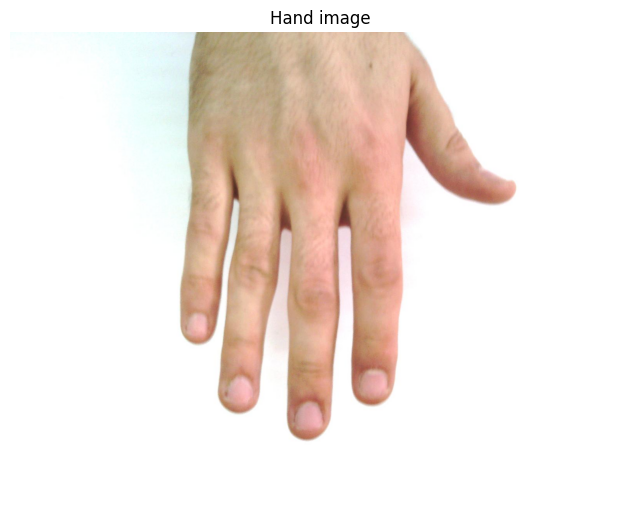

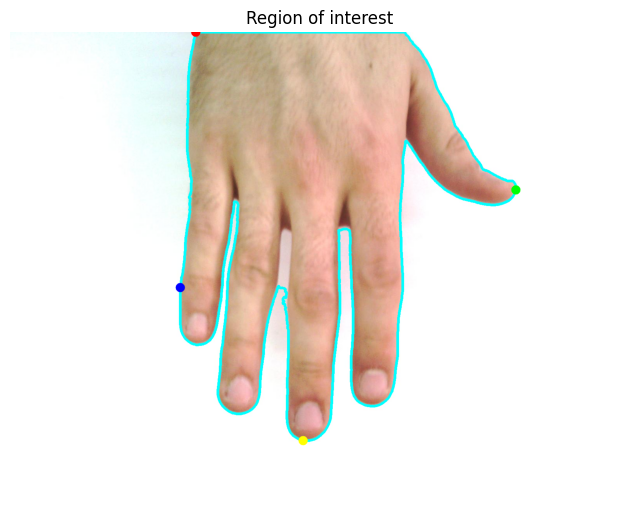

In [ ]:
import cv2
import matplotlib.pyplot as plt
import warnings

def process_and_crop_image(img_filepath, output_filepath, show_plot=False):
    # Read image
    raw_image = cv2.imread(img_filepath)
    raw_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)

    if show_plot:
        # Suppress warning
        warnings.filterwarnings("ignore")

        # Plot the raw image
        plt.figure(figsize=(8, 8))
        plt.imshow(raw_image)
        plt.title('Hand image')
        plt.axis('off')
        plt.show()

    # Convert raw image to grayscale
    grayscale_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2GRAY)

    # Convert to a binary image
    binary_image = binarize_image(grayscale_image)

    # Extract the contour and extreme points
    contour, extreme_points = get_extreme_points(binary_image)
    # print(extreme_points)

    left, top, right, bottom = extreme_points

    cv2.drawContours(raw_image, [contour], -1, (0, 255, 255), 6)
    cv2.circle(raw_image, left, 12, (0, 0, 255), -1)
    cv2.circle(raw_image, top, 12, (255, 0, 0), -1)
    cv2.circle(raw_image, right, 12, (0, 255, 0), -1)
    cv2.circle(raw_image, bottom, 12, (255, 255, 0), -1)

    if show_plot:
        # Display region of interest
        plt.figure(figsize=(8, 8))
        plt.imshow(raw_image)
        plt.title('Region of interest')
        plt.axis('off')
        plt.show()

    # Crop and save image
    crop_and_save_image(
        img_filepath=img_filepath,
        extreme_points=extreme_points,
        output_path=output_filepath
    )

img_filepath = '/content/Hands/Hands/Hand_0000002.jpg'
output_filepath = f'/content/{img_filepath.split("/")[-1]}'
process_and_crop_image(img_filepath, output_filepath, True)

In [ ]:
df_info = pd.read_csv("/content/HandInfo.csv")
df_info.to_csv("/content/drive/MyDrive/Hands Dataset/HandInfo.csv", index=False)
df_info.head()

,id,age,gender,skinColor,accessories,nailPolish,aspectOfHand,imageName,irregularities
0,0,27,male,fair,0,0,dorsal right,Hand_0000002.jpg,0
1,0,27,male,fair,0,0,dorsal right,Hand_0000003.jpg,0
2,0,27,male,fair,0,0,dorsal right,Hand_0000004.jpg,0
3,0,27,male,fair,0,0,dorsal right,Hand_0000005.jpg,0
4,0,27,male,fair,0,0,dorsal right,Hand_0000006.jpg,0


In [ ]:
def create_dataframe_from_images(image_folder_path):
    image_paths = []

    # Count total files to set up tqdm
    total_files = sum(len(files) for _, _, files in os.walk(image_folder_path))

    with tqdm(total=total_files, desc="Processing images") as pbar:
        for root, dirs, files in os.walk(image_folder_path):
            for file in files:
                if file.endswith(".jpg") or file.endswith(".jpeg"):
                    image_paths.append(os.path.join(root, file))
                    pbar.update(1)

    data = {'Image_Path': image_paths}
    df = pd.DataFrame(data)
    return df

In [ ]:
folder_path = '/content/Hands'
dataset = create_dataframe_from_images(folder_path)
dataset.head()

Processing images:   0%|          | 0/11076 [00:00<?, ?it/s]

,Image_Path
0,/content/Hands/Hands/Hand_0010707.jpg
1,/content/Hands/Hands/Hand_0000065.jpg
2,/content/Hands/Hands/Hand_0008062.jpg
3,/content/Hands/Hands/Hand_0000979.jpg
4,/content/Hands/Hands/Hand_0002463.jpg


In [ ]:
dataset['Image_Path'].nunique()

11076

In [ ]:
import os
from tqdm.auto import tqdm

cropped_dataset_dir = "/content/drive/MyDrive/Hands Dataset/Cropped Dataset"

# Process and crop each image in the dataset with tqdm progress bar
for img_filepath in tqdm(dataset['Image_Path'].values.tolist(), desc='Processing images'):
    output_filepath = f'{cropped_dataset_dir}/{img_filepath.split("/")[-1]}'

    # Check if the output file already exists
    if not os.path.exists(output_filepath):
        process_and_crop_image(str(img_filepath), output_filepath)
    else:
        print(f"Skipping {output_filepath}. File already exists.")

Processing images:   0%|          | 0/11076 [00:00<?, ?it/s]

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010707.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000065.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008062.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000979.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002463.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002257.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003870.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005932.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001719.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009674.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008337.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007153.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006431.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005689.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008669.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011436.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006687.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008149.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007449.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004341.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011189.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001012.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003110.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007951.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000236.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006294.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011608.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000524.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011235.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000628.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007421.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007976.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004853.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008695.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005266.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001216.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000042.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004764.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004856.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008099.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010104.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010494.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006947.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000447.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005746.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011527.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006696.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009111.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006375.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000026.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010142.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003020.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003559.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005389.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002502.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010135.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009328.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003947.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005822.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008986.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003084.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010216.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004931.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008498.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001711.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006079.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008590.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002666.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009108.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005110.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000567.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001635.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010675.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000963.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000145.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010465.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004982.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004602.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001476.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009682.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006005.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007877.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009689.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008368.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003089.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006977.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010589.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006842.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001461.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004334.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010542.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010242.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006331.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002888.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002570.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002649.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001899.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010272.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010712.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008783.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002698.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005749.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008824.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005186.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005232.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004996.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011051.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007327.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011036.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004450.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003094.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008577.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003283.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005433.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001709.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011381.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002197.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002608.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004165.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000221.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003083.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003528.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001905.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004960.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004610.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006383.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000826.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000105.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002893.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000883.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002597.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008500.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010400.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001995.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007673.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010818.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008293.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010945.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009734.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002652.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003988.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011199.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008041.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000153.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005174.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006915.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003324.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011072.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003076.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002592.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003287.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003010.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001199.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004521.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006861.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003039.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009916.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009116.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010825.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011550.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000312.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001710.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011216.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007919.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003546.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004627.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005250.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004732.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009198.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004955.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005598.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008766.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006783.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000241.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001830.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008058.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007860.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005333.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002111.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006981.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004177.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005402.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004302.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008971.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010492.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004865.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007136.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010230.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011611.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000561.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006149.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002763.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005777.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007086.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006938.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009466.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003256.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010332.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006429.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010278.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002932.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006275.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009735.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005895.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010338.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005536.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003146.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008912.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008140.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009895.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003211.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010065.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010744.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000160.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000251.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000147.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004623.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003533.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003453.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003893.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011192.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009751.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009317.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004310.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003380.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000977.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002361.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011395.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008189.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011737.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006705.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000264.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007641.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010078.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011597.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005256.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008490.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001267.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005377.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010674.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007056.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001810.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001359.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002044.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007002.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005381.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007504.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005821.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002692.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004538.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006204.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003624.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004909.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011292.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003798.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002120.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011249.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009991.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002419.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006698.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002054.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009989.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005404.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002840.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001192.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006761.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009929.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004107.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008568.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003711.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001278.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008558.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005160.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005279.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010866.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009129.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007444.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009459.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006544.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007282.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004665.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006890.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008594.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006708.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009759.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007190.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006851.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006943.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003775.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004152.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004191.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011660.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006693.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004386.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003096.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003363.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006704.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008785.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003120.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010066.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011520.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002219.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007920.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006552.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006932.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009882.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002852.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005429.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003088.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008080.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000200.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000678.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004944.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001747.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010527.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005497.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004145.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005416.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007443.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007131.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009260.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009098.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006236.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010682.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005791.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002246.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005553.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002008.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010784.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002936.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002754.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003059.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001149.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005460.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003555.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006319.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003902.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010191.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004475.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005809.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005577.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011347.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004889.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009688.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010354.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006744.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004472.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000517.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004701.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011230.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005026.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002089.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003025.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008722.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002628.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002813.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011594.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010958.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000625.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011674.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002375.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000539.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008962.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011604.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004653.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000057.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002969.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005736.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008506.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004099.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009807.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001513.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007438.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000052.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003517.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005836.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007820.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011263.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002556.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009289.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009469.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004423.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010324.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006002.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004648.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009031.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006165.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009959.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005342.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006832.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007266.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006823.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007606.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005375.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009901.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005312.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007661.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006194.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005096.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010981.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007368.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010653.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005225.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001381.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004723.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011744.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006398.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002561.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008984.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001943.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010181.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011152.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005744.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009184.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009064.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009199.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011615.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004418.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005490.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001500.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010517.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010344.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005726.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008221.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003164.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007544.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007425.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000702.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005446.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003933.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003188.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000496.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001326.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007911.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003846.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004651.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008038.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000180.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010273.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010350.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006202.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010988.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005287.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004192.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002260.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001322.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005745.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006623.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009531.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008889.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007558.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000584.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010604.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009394.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011248.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000209.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010567.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009512.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007786.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010425.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009879.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002047.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009986.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009855.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008621.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000705.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005165.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010392.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003470.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009875.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001000.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006656.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002578.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005700.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004900.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002005.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002663.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007480.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005294.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000681.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000385.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000288.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003013.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003952.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010647.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010175.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006321.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003228.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010839.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010266.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006382.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004922.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000711.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007474.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000159.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003438.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002348.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010932.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002646.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002642.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004832.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001332.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003455.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003686.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003359.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002501.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000006.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008941.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001685.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005048.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011679.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006875.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002159.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004452.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005265.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007061.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002081.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000842.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007873.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005235.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001893.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008891.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008303.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003628.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008713.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008446.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010623.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003336.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011474.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003173.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006083.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006807.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004425.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001277.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002575.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005223.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005376.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002926.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007167.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005865.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005286.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009350.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008128.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011239.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011665.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006917.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009024.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004745.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009615.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011180.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001052.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000275.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009748.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009422.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000106.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003754.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011610.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001956.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004811.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008168.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002717.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007536.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009314.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002230.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001457.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002173.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010568.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010766.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009588.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002974.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010802.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002537.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003501.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002367.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002462.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009532.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001063.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006415.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006584.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002550.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010637.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010934.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010393.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000112.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011742.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010212.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005064.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004006.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006812.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002200.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007764.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005920.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007013.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010127.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005721.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007875.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003130.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008400.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008161.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010904.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011647.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010966.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007734.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003567.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009374.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002271.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001299.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006886.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001106.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006762.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004852.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009782.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006604.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005346.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006461.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001169.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006139.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004656.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000889.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006419.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011177.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003709.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002601.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007392.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001994.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010880.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010239.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004798.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001678.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006663.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010719.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004093.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007202.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009582.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001138.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011417.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008481.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003618.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010777.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002879.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003371.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008886.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002070.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009517.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010434.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005756.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004632.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009506.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005615.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001092.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004700.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010437.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002510.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005444.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001872.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005504.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008990.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009385.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009564.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010466.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001572.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002683.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009805.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002715.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002335.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002188.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007133.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008920.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011419.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004988.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007917.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009561.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010756.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007868.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006108.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009955.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011531.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004705.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006447.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009161.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005251.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005121.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001740.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009654.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002685.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001185.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007930.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010292.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011350.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007712.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008191.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001017.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005531.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011706.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000962.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001998.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005268.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002768.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001101.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003810.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010092.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008668.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005880.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011452.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010095.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008759.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007251.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004639.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003864.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003493.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000696.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000502.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005278.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008532.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008361.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000507.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000413.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006550.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003099.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009649.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007685.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008921.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001989.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010732.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006889.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006179.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004336.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008735.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011641.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000197.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004760.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009343.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003809.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005737.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006072.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006006.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004134.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009869.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003224.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008159.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004301.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009485.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000095.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007884.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011150.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006905.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001811.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002179.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004816.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007509.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009425.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011121.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010723.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005968.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003006.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005550.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004188.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008473.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005386.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000472.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000953.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004058.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008258.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006948.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009940.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001244.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011035.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005952.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009097.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008015.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004730.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001757.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002182.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000490.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009432.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000278.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005155.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006606.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010580.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001118.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004517.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005565.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011080.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004297.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001616.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005164.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008715.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005856.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009155.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003000.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006155.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007234.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003255.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005881.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007624.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006454.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010101.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003423.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008611.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005568.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010047.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000012.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000992.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005020.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003497.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007757.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008377.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002027.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000970.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010851.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009736.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004130.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003353.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008622.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002999.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003366.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000909.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007364.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005799.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011483.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004572.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008237.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010362.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011388.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008583.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010667.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000135.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000167.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001884.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009787.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002699.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000421.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004495.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004711.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003124.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002898.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001114.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010091.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008282.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000263.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010029.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003796.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000775.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000287.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003446.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008053.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009190.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001184.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005886.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002156.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010007.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005848.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000416.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005272.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007988.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001532.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010694.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006215.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011100.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006206.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007409.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010299.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003040.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010291.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008276.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008539.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001348.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009160.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008879.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001730.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004938.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004103.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000892.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010164.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006066.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002249.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011043.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008474.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010695.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005854.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003179.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001829.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001441.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009242.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001983.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000406.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010203.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000054.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007650.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004800.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007529.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011521.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000638.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006043.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008602.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002558.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009629.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000248.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002498.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002504.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009109.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006748.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011302.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009355.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003177.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004607.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006244.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003645.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008796.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007097.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011387.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006982.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000267.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005858.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009579.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008698.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008105.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002522.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005804.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007028.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000866.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006432.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005664.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010113.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007337.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008005.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007591.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009538.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001358.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011044.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010062.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007088.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008164.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008419.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007808.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002890.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011153.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008354.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002706.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001495.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004522.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001792.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006554.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000004.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009249.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006813.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011519.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009164.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004075.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011494.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001312.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003529.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010043.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003909.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006908.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010895.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005157.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005611.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008173.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001465.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009743.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002226.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000589.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004367.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002861.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003544.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004749.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011501.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006591.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004642.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011378.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004142.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002567.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006246.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010402.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002867.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007250.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004527.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005924.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007750.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003650.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006140.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011481.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011259.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007792.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003978.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005158.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007100.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000951.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007621.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002313.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008326.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010797.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005967.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003744.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001900.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005946.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002870.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009061.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007096.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001816.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009315.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006583.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010143.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010179.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001610.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008095.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002895.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011348.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001823.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005145.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008464.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006170.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003252.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000766.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007609.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005315.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009673.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010979.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010114.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000394.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007040.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010807.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000219.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000020.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000271.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011625.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004102.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005291.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004108.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004897.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001237.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005360.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004400.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010491.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007146.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004541.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004502.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005682.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005177.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003972.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002906.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008600.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004972.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005047.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003779.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010928.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010940.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004526.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003062.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010188.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011071.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003751.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008090.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009044.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001563.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000630.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004919.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007469.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000377.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007984.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008031.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005883.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007872.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011739.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002753.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010165.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000518.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009559.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009602.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003125.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000882.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011532.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011477.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010443.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006090.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009600.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007017.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011718.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001651.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010793.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009002.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000640.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006883.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008524.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006525.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008477.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003860.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002571.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002034.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008027.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010776.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007756.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011631.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011517.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008764.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005318.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006288.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006496.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010622.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002253.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000607.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011242.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002681.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004196.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000621.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007324.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005371.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002147.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007982.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001434.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007423.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002437.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005750.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005907.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001053.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008320.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010463.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003289.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001785.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004677.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011327.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008955.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000522.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008199.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001072.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005317.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008383.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002758.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007356.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003992.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009769.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010138.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010894.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004719.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010594.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005077.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004511.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008982.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008353.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003706.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008440.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002946.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007863.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008046.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000092.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010590.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004649.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008193.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008308.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004141.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004953.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011137.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004969.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003352.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006080.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009055.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009713.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011617.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008079.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005575.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007456.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004787.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008379.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010284.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003871.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011415.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000926.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000023.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001509.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004104.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007019.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004437.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007288.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011564.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009071.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006127.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002238.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009737.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008037.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007069.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008684.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003713.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004320.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010245.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000753.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009762.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000411.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008519.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006313.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009026.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005249.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007599.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007024.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010824.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011156.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003253.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006484.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007674.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001848.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009856.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010384.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001529.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002802.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009597.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007394.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002125.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002324.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004326.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004225.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006261.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003452.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001365.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001779.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010714.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000378.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008745.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001911.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010923.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008449.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002216.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009990.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008913.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008285.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011548.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003505.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005117.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000293.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007336.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002252.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007424.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006749.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010106.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001858.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006353.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008286.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006953.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005559.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009573.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010183.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005840.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007755.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001194.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007608.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008857.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004726.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004440.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011059.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000952.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009340.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005680.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009136.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008933.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007489.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004404.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009178.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002539.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009089.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009819.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010832.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006146.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004082.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009636.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011000.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005593.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000090.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007035.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006147.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004344.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001377.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007730.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011178.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007825.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002084.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002397.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003071.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004967.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011637.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002777.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010835.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002487.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007170.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006799.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005959.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005557.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004631.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003485.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011145.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011146.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010811.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003680.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005219.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000656.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002028.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005220.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009745.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002555.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000884.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005363.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005085.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011546.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001862.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008222.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009115.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003961.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004491.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006736.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003836.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002750.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000046.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004419.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011622.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011215.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007721.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002275.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001691.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002443.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003581.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008606.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006269.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001236.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004466.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002319.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002347.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001247.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004557.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011493.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011598.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010064.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007815.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002193.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010341.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007890.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009903.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000906.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005451.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010115.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009206.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010804.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007192.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006121.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003405.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000318.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007085.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004067.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004453.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005390.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009258.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005353.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000146.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008382.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006451.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000473.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002251.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008054.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003640.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002132.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010865.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001924.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004699.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010314.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003444.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000265.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009465.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010786.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000013.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001243.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007319.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006547.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010193.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005432.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002547.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010953.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000199.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008865.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000666.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005179.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006428.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006107.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008123.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006305.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005126.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005001.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004812.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004793.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005112.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008020.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004814.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009625.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003241.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007166.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007119.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011743.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010591.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001395.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010001.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010942.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008751.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010041.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005022.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010137.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008150.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002332.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002748.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001345.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008671.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005871.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010575.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010536.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004663.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002927.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009784.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002338.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011559.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005740.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002455.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003507.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007995.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004973.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005503.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001630.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005999.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008800.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002824.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005595.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010538.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009802.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000736.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008211.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009259.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002947.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008374.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008625.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010555.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010828.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000733.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003108.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006456.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008934.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010229.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008399.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008697.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008174.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003584.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011082.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009628.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011416.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006903.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001585.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005418.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011408.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004043.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001397.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005969.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003623.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003127.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004393.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001664.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011393.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007500.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000720.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003774.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001676.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003266.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007948.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009174.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006983.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010907.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010857.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006374.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009962.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007476.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007144.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010845.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001667.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004537.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007862.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011402.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007711.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004724.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010451.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009529.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003467.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006918.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004018.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009011.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008973.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007703.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002769.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006171.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009195.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007562.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005904.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002975.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005509.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004187.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001142.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006310.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001087.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001221.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005602.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005667.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004256.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001663.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007237.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005484.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007632.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006176.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007041.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005609.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006264.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009288.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010795.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008614.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011377.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003837.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004325.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009439.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001636.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011306.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010260.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005462.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004797.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008190.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000104.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007138.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002707.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009051.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003234.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001024.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004154.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006023.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006804.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008995.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007483.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009256.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001986.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010117.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006734.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010040.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001046.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006669.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011624.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009868.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004740.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010220.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002530.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006561.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009988.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006599.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003330.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010084.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003284.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003991.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007333.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005523.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008089.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004446.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011046.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006022.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004570.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003197.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007338.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010217.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005467.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010704.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008143.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006407.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009930.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011201.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002410.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004886.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011406.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009159.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010461.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007283.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003321.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005236.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007943.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005028.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011014.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010129.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010503.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010021.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007704.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002952.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003504.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006460.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009852.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005184.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003356.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005479.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004542.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004694.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000077.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000792.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007514.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003561.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009780.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001922.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001873.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010017.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003184.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003783.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011289.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009606.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011131.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005616.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003606.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010122.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001962.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003172.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004476.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000429.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003889.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004863.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007491.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005073.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009565.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004356.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007568.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010401.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006531.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000852.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004109.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000560.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002956.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003875.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002072.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009834.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007994.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002616.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010930.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009151.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010679.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008373.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005320.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003026.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008782.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008732.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008312.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008740.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007694.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004221.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001864.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009521.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009252.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005041.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002521.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004421.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007918.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003042.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011576.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011382.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011333.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006659.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011212.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004571.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001949.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011078.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006560.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006345.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006898.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009979.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007646.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008544.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002475.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005849.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006895.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003770.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009230.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001612.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010307.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004562.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003699.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004170.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004619.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009708.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005625.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011374.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000546.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007450.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001286.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008977.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008721.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007418.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000695.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007440.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004215.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004328.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009327.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005298.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004558.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006860.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009702.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010283.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005549.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010905.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008929.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004803.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000748.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009342.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005719.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005292.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008307.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002269.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003800.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002998.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008801.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007905.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011160.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007665.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010659.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004871.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006936.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008253.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001231.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010380.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007091.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003833.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001846.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004808.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001447.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006992.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000226.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003882.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003874.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000627.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007345.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004772.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003549.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006013.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001966.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003123.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006962.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005163.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001519.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005237.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006021.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007688.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006466.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000427.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005788.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005019.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003077.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001738.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001627.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006291.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011055.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010480.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006833.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011221.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003912.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004921.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011269.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005751.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003589.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001246.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006646.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001360.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001783.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011459.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002759.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004258.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001269.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000914.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008465.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002993.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002265.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007304.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000177.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011099.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011187.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006362.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011077.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000292.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007270.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009753.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005752.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001584.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007894.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008522.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009419.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000932.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009684.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004483.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004737.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001502.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010628.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008928.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008073.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003788.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006642.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001702.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011700.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006402.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010152.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001077.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002954.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009411.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000831.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001248.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007309.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001323.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007410.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003030.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009694.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004219.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007795.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001867.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006763.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005594.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008325.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009030.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010248.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006476.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005838.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006504.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008565.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001180.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001743.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009951.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002484.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006485.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009656.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001468.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010031.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009493.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008026.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000134.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008229.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008563.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007067.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003078.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000060.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003993.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002959.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007354.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000419.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001677.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010740.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003776.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009896.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002785.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008786.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008043.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003866.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005132.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002400.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006289.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010033.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009886.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000937.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006241.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011154.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005187.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001976.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007312.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008833.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003118.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010271.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006766.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006221.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009828.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004770.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004826.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004679.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005927.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008757.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005269.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003499.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009080.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009273.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001222.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007362.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007044.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003689.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008831.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009797.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003793.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000810.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000067.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008185.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000547.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009971.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008731.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007728.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009530.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003617.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000308.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011397.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001815.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006825.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010293.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010893.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009219.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005926.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008657.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008670.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000432.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008772.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011593.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002678.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009200.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008078.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010018.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006380.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006337.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010457.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010046.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001759.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007523.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009118.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001772.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003305.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008121.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002563.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004802.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007341.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010334.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000783.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008448.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007052.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008814.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006896.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009378.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008492.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006015.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002145.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000315.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003532.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009270.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009733.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011049.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003317.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008862.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005171.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001791.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004457.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011148.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003728.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004434.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004444.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003190.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001670.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008245.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010505.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008230.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005815.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006040.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007169.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010899.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002739.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007343.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007054.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002687.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009873.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010576.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000224.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008480.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004968.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004300.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009982.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000021.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005364.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007887.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011284.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008406.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003351.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005063.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004682.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008644.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005209.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000820.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002900.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004628.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010369.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004022.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007436.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003472.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002523.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008546.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008134.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007242.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007372.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004384.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007320.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011640.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006220.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001552.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002960.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009065.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001350.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000680.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004833.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004769.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009821.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004106.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003186.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002350.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008672.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006726.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007335.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006252.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011008.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003691.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009175.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001640.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003437.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001762.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005383.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005282.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009215.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006621.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004549.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006333.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008378.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002949.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009609.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001904.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009225.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000877.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005922.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007908.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007866.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006984.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002564.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007565.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011669.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005495.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000111.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003685.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007009.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000864.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002444.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003214.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009668.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001109.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009639.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001717.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002876.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004059.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011334.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004983.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009400.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004830.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007276.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008214.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000549.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001789.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008689.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002542.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001317.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007179.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001758.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008268.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007835.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011511.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004762.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000716.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008911.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003343.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006287.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003097.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000623.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002099.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010672.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000103.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010398.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005558.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010490.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010204.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002192.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002422.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011656.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007889.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002675.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009123.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010616.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007207.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007399.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004945.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001953.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001508.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000519.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008890.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007365.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009790.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006038.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007472.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008580.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009528.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009470.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011173.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008559.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007047.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011618.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005934.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005366.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002425.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000986.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002508.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003090.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010518.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004875.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006814.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008711.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008077.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004584.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000751.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010140.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003278.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000010.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000942.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000863.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004181.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000424.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001901.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009066.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007033.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004867.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003818.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002235.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003802.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006684.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011741.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004926.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003602.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008384.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009963.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003230.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009572.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010724.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000685.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010801.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002738.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003578.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002605.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004324.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011595.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009431.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009616.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006497.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005889.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005753.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002832.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011502.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007428.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000165.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004936.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007903.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011314.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007871.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009812.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000955.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007280.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005963.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004704.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005878.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003333.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007176.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003983.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005000.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011196.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000459.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010415.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010391.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005400.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002724.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010166.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002411.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007675.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006624.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007945.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009710.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007986.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007846.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007198.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003458.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008893.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009974.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008178.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008270.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004016.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002933.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002757.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001469.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002139.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006512.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007869.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006821.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002181.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009114.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005628.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006535.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004277.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004768.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011612.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009920.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008630.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000347.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006162.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007210.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006296.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010448.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005486.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008537.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005498.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005332.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004794.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010948.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001773.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008309.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008415.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010120.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009969.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000661.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008434.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008566.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000854.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002010.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005864.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003516.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002853.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005505.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010565.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009028.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001729.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001352.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011111.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004963.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006397.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004578.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005662.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000449.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003594.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002118.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005175.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004254.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004299.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000984.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007363.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003777.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001853.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006798.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000576.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003705.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011723.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006479.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002657.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011338.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009338.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008349.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005138.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008240.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001006.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002511.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002773.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005707.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004508.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011004.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005786.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004486.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000737.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011285.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005613.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008661.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007760.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009255.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011007.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008203.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009519.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003111.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005875.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011047.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002517.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000349.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008648.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007698.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009189.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004153.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005356.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002524.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007045.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001562.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004767.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005152.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003949.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007827.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002036.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007339.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008925.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005947.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005195.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007359.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002650.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009286.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010608.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002633.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003897.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003590.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010487.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003876.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003015.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003805.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004662.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003032.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003420.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009085.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001178.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005474.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007094.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005491.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008441.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007106.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005627.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002519.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007904.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007556.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002288.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009826.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002273.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003863.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004882.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004940.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000850.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011194.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003823.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002858.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007485.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002124.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004460.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006805.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011101.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009148.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007545.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008176.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007959.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003290.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008162.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003626.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008978.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003116.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003465.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002399.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010607.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003812.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010579.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009347.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004054.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002907.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003160.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000791.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010748.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010311.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002873.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009508.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004186.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006534.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001558.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011198.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000324.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009936.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004327.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008087.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009388.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008538.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002924.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007946.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006803.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010836.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003422.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009642.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002985.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008974.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010619.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009918.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010849.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002152.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008706.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007727.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003495.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003113.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010069.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007286.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002670.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009416.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008821.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007108.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000218.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004937.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002533.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005931.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007311.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001820.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001318.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011357.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000807.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004156.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010790.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002976.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002827.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002110.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008878.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004552.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004121.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010356.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003541.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011607.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006480.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003203.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000686.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009113.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007064.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003136.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001253.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002215.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000096.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004775.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000097.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009291.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002321.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008057.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006686.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002645.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001945.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003782.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001430.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002817.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002294.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001687.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004547.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008393.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005190.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002632.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005450.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008543.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000972.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009468.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005771.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011735.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009816.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000458.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008250.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004236.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009835.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006039.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006958.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006156.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002631.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008317.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006614.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003873.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001455.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009627.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005070.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011329.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005290.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005506.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001890.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004693.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007347.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004210.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011441.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011445.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005801.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002557.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003019.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001579.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003930.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006044.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006064.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011662.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008967.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011210.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003175.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006828.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003250.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002176.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003194.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007937.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009117.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004412.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010103.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011390.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000309.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010960.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006538.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003067.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007022.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006968.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007075.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003815.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002863.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009180.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006255.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004598.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003726.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005618.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009212.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009221.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003261.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009481.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000085.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002272.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004725.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009101.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008528.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004530.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010336.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007739.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005299.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004622.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008663.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004952.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011045.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003112.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005530.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000998.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005782.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008719.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005683.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005069.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008097.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009420.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005463.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008994.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011654.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003538.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003365.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009133.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010395.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000266.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006590.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003244.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008157.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008926.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005144.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004626.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011211.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000431.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009933.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003260.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005653.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000074.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005794.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005254.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005119.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011109.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002931.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001869.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011144.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002414.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004592.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006743.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007779.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006818.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008453.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010986.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003557.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006042.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009704.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007806.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009809.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008166.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008747.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002565.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010639.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003280.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001383.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008887.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002093.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009099.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011002.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010896.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003311.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009789.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010991.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003052.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007847.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005153.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010464.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007783.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005101.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006024.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010061.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004241.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001965.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006513.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002088.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002040.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007128.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000282.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010747.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009448.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002741.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001440.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008216.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007713.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008910.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008592.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001145.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000617.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002958.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005966.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006150.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007420.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009998.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002512.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003547.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001567.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011562.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003119.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006284.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000100.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004244.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006792.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004801.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001218.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003147.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001357.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000333.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004652.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007442.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001918.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008273.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007651.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007072.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000515.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010255.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007576.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010837.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004915.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010159.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007519.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001019.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005156.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002296.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010781.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009534.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004381.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002953.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001512.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002705.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008234.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006788.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005185.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004073.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008547.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010209.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009871.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003919.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002234.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011220.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006553.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011021.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011664.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001594.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005543.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006829.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009170.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001156.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003830.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003463.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008488.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004083.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003583.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009635.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001086.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004333.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009960.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002451.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010864.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005092.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002624.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002973.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004990.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002416.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010840.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009825.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003058.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009577.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004090.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010358.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008104.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006835.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005853.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004586.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002123.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007582.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003757.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009614.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001420.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002689.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000844.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011323.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007221.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004033.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009718.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003029.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009220.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007567.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004471.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007185.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006845.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003313.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003865.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001822.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005188.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002846.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010609.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005501.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010206.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007716.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010962.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004335.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000902.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002378.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007885.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007682.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008287.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004962.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000520.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009599.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001545.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007584.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001056.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007828.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004237.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003712.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007215.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003248.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005204.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006049.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010285.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007453.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007152.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006213.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009285.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002426.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008022.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005123.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007751.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005410.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001881.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006689.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005935.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007087.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003397.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008427.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004045.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001835.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009231.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009282.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005243.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006175.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008217.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005207.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010955.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004482.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007284.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007386.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004428.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004783.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006946.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009397.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009919.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010118.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008212.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007111.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003310.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005528.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006673.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010750.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011591.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001104.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003784.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000651.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000580.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001151.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003861.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000235.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006754.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009803.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004765.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008587.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002278.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007053.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004636.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000997.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011526.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006972.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009228.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005978.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000795.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007882.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009774.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006421.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007321.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004920.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002778.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010713.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008198.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001707.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010128.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008110.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011475.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009908.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001895.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008573.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005825.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005113.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005770.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007532.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010027.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006573.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001427.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010342.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005897.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005331.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002812.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002719.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001319.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002737.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007736.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011414.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004323.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004211.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006536.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006488.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009052.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008591.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005870.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003477.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007691.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001645.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009245.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007473.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006986.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008350.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003447.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002460.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008965.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008753.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006148.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002865.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005560.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010522.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009351.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010950.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001421.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003132.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005091.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003682.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005487.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002734.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007458.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005516.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010993.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004068.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007470.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004532.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011411.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001032.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004167.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006964.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002136.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000825.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000504.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011139.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010709.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008739.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001749.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003462.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004026.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008983.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009417.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005267.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001067.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007142.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006732.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000845.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010151.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008927.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004728.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002930.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002135.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002792.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000744.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009072.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003176.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003396.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010875.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001112.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004763.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011534.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004118.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003322.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006529.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004824.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000982.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008907.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010710.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007638.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008033.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010190.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006203.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004395.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004131.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010967.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002239.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008295.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005702.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009830.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004678.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008736.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006361.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003927.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001372.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008219.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009194.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003354.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009424.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006278.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003298.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008595.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004340.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001595.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002573.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007928.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003716.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010728.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002030.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004859.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007457.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009268.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009244.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002075.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001158.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008065.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001716.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008114.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006688.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004928.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005066.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000988.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004617.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001344.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009345.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003381.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006695.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004773.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010268.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010387.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004650.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010365.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004399.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002077.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003101.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008691.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005970.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010295.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005965.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000991.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011707.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003236.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003288.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008343.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007279.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002303.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010024.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006934.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009086.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002830.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011275.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011280.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008808.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006665.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007746.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003847.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001745.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002923.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008425.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009589.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009584.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008455.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002797.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002007.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005670.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001934.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005738.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011170.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002194.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008254.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004893.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003064.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007892.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000123.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007358.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010423.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005679.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000175.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000545.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011464.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009336.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007050.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007076.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011443.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011458.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007507.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009077.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008112.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010715.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009487.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006867.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008138.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007395.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002818.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003307.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000718.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000762.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002905.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011512.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009444.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004950.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006078.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007093.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006757.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005437.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006462.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009165.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007643.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009185.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009382.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006235.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007647.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001596.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009143.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005971.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001308.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011034.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005522.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003426.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005941.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001119.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011552.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009056.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008333.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005731.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009657.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003673.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010867.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005996.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008201.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009558.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002814.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006290.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002548.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011716.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009563.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001165.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008518.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006276.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011332.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005982.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011623.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007155.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005961.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002063.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010770.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009488.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008421.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002992.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009516.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011360.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004292.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000840.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007731.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010531.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005874.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000322.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009526.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005778.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005173.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001375.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006989.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000830.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000047.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007729.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007705.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006996.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003898.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009110.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000676.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007352.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009504.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000326.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008036.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000255.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000229.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009560.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000886.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002233.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007124.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010366.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007051.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003551.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000981.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004014.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009392.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004655.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008604.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010708.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005513.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001701.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008482.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007824.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001987.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002353.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004253.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004354.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001174.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011309.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008362.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009865.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002815.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011485.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008847.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007821.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005336.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010900.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007396.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004259.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007330.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003611.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011331.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001330.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005567.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008738.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007212.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008067.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008356.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008617.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002343.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004383.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007616.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007446.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003613.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005466.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004981.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009709.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001347.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005473.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010052.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001276.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005876.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006137.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006840.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010139.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004720.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010662.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002979.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008458.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002822.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010042.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003652.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000817.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011074.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003840.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004971.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007893.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010848.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004818.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004535.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010856.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010259.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002676.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007595.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002168.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006755.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002672.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009892.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000540.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004840.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009546.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010074.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011492.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001144.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002892.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002774.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002515.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009618.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008658.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003707.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009087.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001037.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002107.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005016.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005803.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006559.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004790.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004641.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006876.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003491.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005826.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007798.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000834.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006764.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001150.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009500.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009272.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001649.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002342.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005624.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010168.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008636.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007697.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006017.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005555.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011386.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004282.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006101.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004469.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001605.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007759.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006619.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011243.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010460.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001878.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007922.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008319.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009179.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009019.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002208.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005754.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004735.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005983.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002752.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011561.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005213.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001036.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008381.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011175.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005554.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006123.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010762.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001561.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009025.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008327.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011048.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010326.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003338.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011054.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006727.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011209.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007281.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002842.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007479.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008714.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010706.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005793.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003914.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007662.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006309.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003490.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004359.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001313.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010974.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000420.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007349.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010808.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011224.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009124.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011095.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002980.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002292.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006474.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009404.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001202.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002357.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008442.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004030.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010598.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005524.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011362.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006073.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004633.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002020.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009840.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001680.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010806.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006970.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004643.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008603.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001516.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008826.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000837.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002911.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001541.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005658.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009337.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010450.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010885.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004315.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005310.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000915.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005938.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002069.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011326.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007601.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011253.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004978.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006009.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007543.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000813.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008215.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001471.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002207.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000055.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002050.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005172.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008688.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008098.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005884.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005036.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008809.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007492.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004220.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001620.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007134.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005698.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005439.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003772.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009251.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005713.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000488.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002751.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007633.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002247.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006671.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004524.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001283.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006640.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001367.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000079.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002702.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007414.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003894.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006692.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006311.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003223.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008734.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006965.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007000.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001999.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008329.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010858.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008760.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006549.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004470.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010081.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004464.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002804.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011423.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007830.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005494.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008985.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009641.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007168.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004493.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003939.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007620.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009384.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009909.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006143.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003508.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010452.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004667.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006998.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011555.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002607.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007248.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004463.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002014.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008593.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011535.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004799.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007765.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005706.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006370.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004779.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008819.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000031.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009764.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009525.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003973.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008457.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003346.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009954.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001353.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011466.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000390.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002287.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006433.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000814.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004885.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000208.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005276.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001672.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011257.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001777.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009926.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009461.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011613.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006328.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002227.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009822.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008520.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010136.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005245.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005668.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007099.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002323.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002694.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002684.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008659.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008255.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002915.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003681.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005747.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007030.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003156.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003121.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008158.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000220.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006856.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004634.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005099.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007244.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002883.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000936.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009187.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000603.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007574.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007604.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001805.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004673.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001113.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008830.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010447.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005044.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005062.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005981.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010577.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009182.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008575.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009032.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001235.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005449.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009738.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009817.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003258.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009720.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006448.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004339.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005948.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009387.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008998.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003488.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008882.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008023.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009386.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008141.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005050.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000140.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003924.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001533.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011619.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003773.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011233.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001293.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008999.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011151.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003454.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006902.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006219.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000768.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002582.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010584.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010749.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008391.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003642.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006135.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010160.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011518.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003109.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007369.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004843.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003360.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009697.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008372.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006001.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008937.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004272.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011399.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001700.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011692.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006051.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011371.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000731.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010394.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009473.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000383.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002237.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007681.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009020.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009410.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001090.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010364.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009038.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001004.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011601.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009433.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003107.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001342.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007454.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001526.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003620.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005293.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001098.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000084.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004029.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006830.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001806.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006330.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010149.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002248.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007114.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006555.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003921.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004403.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010226.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002641.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006793.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008850.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003855.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011025.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006363.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008339.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000993.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011190.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000521.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001879.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003997.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007999.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005917.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007915.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010644.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002067.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002725.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009027.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001402.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010171.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007811.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009434.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004201.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004548.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000583.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011524.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011491.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005438.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005984.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007462.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002333.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000456.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001542.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009902.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006967.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010125.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007588.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011142.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003827.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006387.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005103.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000215.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011282.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008542.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006795.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008186.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002732.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011184.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006767.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002113.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005956.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002122.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004601.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007506.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003158.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005072.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001624.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006217.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006667.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004000.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010424.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008763.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009847.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002236.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011218.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009054.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007306.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001609.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009947.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006436.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007839.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010397.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002507.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000107.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004778.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011161.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011103.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011157.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008665.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002545.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010082.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001974.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000604.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002837.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008773.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009944.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006678.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010389.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010685.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008231.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004533.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001920.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008991.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000428.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006848.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003037.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009406.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001084.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007161.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002611.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003080.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000878.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007654.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009613.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009100.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007517.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002680.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000650.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001703.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010741.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000742.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002747.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008839.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007049.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003975.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011573.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007255.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009693.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006400.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006125.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002845.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000444.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009864.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004683.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007503.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004375.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003932.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009767.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007924.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007676.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009510.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004959.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001656.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005703.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001126.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003862.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002781.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005166.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006729.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000513.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002593.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009964.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003481.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001638.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006722.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003804.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005493.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003646.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001042.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005819.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008992.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008345.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006166.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010156.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010488.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009357.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010733.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006119.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002636.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006360.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007290.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003456.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000122.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007672.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005469.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005328.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000612.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002320.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003269.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007956.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003695.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000726.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009010.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004496.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004202.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006470.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009021.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008321.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010677.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011592.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000633.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007104.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004389.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005406.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002078.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001163.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010854.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010994.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003460.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001197.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011186.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002779.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011245.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003747.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002476.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002554.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005109.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009914.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003402.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002281.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010323.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010869.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007572.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000525.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004479.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006521.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009961.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007850.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004657.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003690.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005285.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009775.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008223.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011228.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006746.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001684.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011112.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004051.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005592.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004116.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009132.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005241.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001802.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002079.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005979.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000381.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004252.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003957.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009744.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006338.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010277.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004658.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003410.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008484.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009666.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009457.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002438.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002384.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001337.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003017.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003872.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005629.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005492.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000565.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009121.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002459.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004687.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009815.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009527.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006089.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007057.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010060.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010170.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003848.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006582.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005454.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005656.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010612.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000501.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002760.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005191.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007077.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007780.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001370.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002368.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004174.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004646.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007593.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000569.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005643.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004149.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004594.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009540.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007020.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009211.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007230.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006020.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009207.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005573.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010687.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004304.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004427.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007413.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005319.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002157.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005193.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008793.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000133.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006999.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005373.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007351.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002166.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006420.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005146.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005309.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009687.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008923.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007393.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005263.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011426.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001972.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008196.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004439.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003008.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004239.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001903.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003639.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002160.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008330.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007979.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007143.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009543.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002984.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000667.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005579.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003390.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009849.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006815.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007398.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003251.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004766.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002871.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010581.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005009.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008607.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005205.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007180.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002291.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002772.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004785.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007579.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010929.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009679.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006647.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007735.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011456.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006283.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006794.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001071.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004964.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008579.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004587.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009575.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003895.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007953.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004387.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005548.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006372.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002643.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008360.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009234.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000596.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009880.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008885.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007809.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000450.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004285.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007940.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011164.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007548.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011686.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007258.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005734.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003191.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003934.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011020.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005541.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010757.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007874.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000482.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006315.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008987.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004147.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011315.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004127.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008010.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010167.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001673.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002385.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010235.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006210.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004784.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005776.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005709.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007005.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003151.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003337.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010643.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000256.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008534.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011129.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003838.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000388.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006368.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000847.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008947.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002297.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002151.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004066.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005762.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003918.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006422.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009842.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011663.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002011.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001646.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005542.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011115.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007555.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009196.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001304.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004038.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011232.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000755.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008040.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007427.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008730.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001957.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006181.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007297.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006741.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000778.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006322.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002855.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005005.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003829.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001195.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006773.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009264.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009846.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009583.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008664.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000086.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003312.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006625.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007060.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009034.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000157.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004579.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003140.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005508.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003332.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011359.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011487.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009980.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010730.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008898.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002695.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004680.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002377.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001047.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008238.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000994.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000433.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010668.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009772.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010673.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003740.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005644.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001642.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008489.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006922.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005590.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005648.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011684.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001504.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005151.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009428.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001564.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008823.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009632.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010782.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000708.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009197.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001453.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003767.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004144.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002942.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008744.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008213.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008130.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003593.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005071.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001491.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006097.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011558.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002211.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010184.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002653.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009696.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010008.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008853.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011412.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008806.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008864.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008034.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008438.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002083.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009768.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004020.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002092.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003572.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000040.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004834.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009823.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006849.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008875.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009706.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011422.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005830.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006870.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006438.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010089.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003267.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006242.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010429.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000876.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004280.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010108.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009048.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008975.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004514.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009729.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001857.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002427.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0003200.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001752.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002495.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008616.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001560.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0000632.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0011339.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004485.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002471.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0006973.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008554.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002029.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010768.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009418.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008802.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008275.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008787.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008950.jpg. File alread

Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007274.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005911.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002199.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004175.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0007752.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0004089.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0005374.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009505.jpg. File already exists.


Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008236.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001514.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010844.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0002489.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001877.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0008423.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0009067.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0001260.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010270.jpg. File already exists.
Skipping /content/drive/MyDrive/Hands Dataset/Cropped Dataset/Hand_0010124.jpg. File alread

# **Loading Cropped Dataset**

In [ ]:
folder_path = '/content/drive/MyDrive/Hands Dataset/Cropped Dataset'
dataset1 = create_dataframe_from_images(folder_path)
dataset1.head()

Processing images:   0%|          | 0/11076 [00:00<?, ?it/s]

,Image_Path
0,/content/drive/MyDrive/Hands Dataset/Cropped D...
1,/content/drive/MyDrive/Hands Dataset/Cropped D...
2,/content/drive/MyDrive/Hands Dataset/Cropped D...
3,/content/drive/MyDrive/Hands Dataset/Cropped D...
4,/content/drive/MyDrive/Hands Dataset/Cropped D...


In [ ]:
dataset1.shape

(11076, 1)

In [ ]:
dataset1['Image_Path'].nunique()

11076

In [ ]:
def concatenate_info_data(dataset1, df_info_copy):
  dataset1['imageName'] = dataset1['Image_Path'].apply(lambda x:x.split("/")[-1])
  dataset_new = dataset1.merge(df_info_copy, on='imageName')
  return dataset_new

In [ ]:
df_info_copy = df_info.copy()
df_info_copy = df_info_copy[['imageName','age', 'aspectOfHand']]
df_info_copy.head()

,imageName,age,aspectOfHand
0,Hand_0000002.jpg,27,dorsal right
1,Hand_0000003.jpg,27,dorsal right
2,Hand_0000004.jpg,27,dorsal right
3,Hand_0000005.jpg,27,dorsal right
4,Hand_0000006.jpg,27,dorsal right


In [ ]:
dataset_new = concatenate_info_data(dataset1, df_info_copy)
dataset_new.head()

,Image_Path,imageName,age,aspectOfHand
0,/content/drive/MyDrive/Hands Dataset/Cropped D...,Hand_0010038.jpg,26,palmar right
1,/content/drive/MyDrive/Hands Dataset/Cropped D...,Hand_0001286.jpg,21,dorsal right
2,/content/drive/MyDrive/Hands Dataset/Cropped D...,Hand_0010818.jpg,22,dorsal right
3,/content/drive/MyDrive/Hands Dataset/Cropped D...,Hand_0004179.jpg,21,dorsal left
4,/content/drive/MyDrive/Hands Dataset/Cropped D...,Hand_0001111.jpg,22,dorsal right


In [ ]:
dataset_without_cropped = concatenate_info_data(dataset, df_info_copy)
dataset_without_cropped.head()

,Image_Path,imageName,age,aspectOfHand
0,/content/Hands/Hands/Hand_0010707.jpg,Hand_0010707.jpg,22,dorsal right
1,/content/Hands/Hands/Hand_0000065.jpg,Hand_0000065.jpg,27,palmar left
2,/content/Hands/Hands/Hand_0008062.jpg,Hand_0008062.jpg,21,dorsal right
3,/content/Hands/Hands/Hand_0000979.jpg,Hand_0000979.jpg,23,palmar left
4,/content/Hands/Hands/Hand_0002463.jpg,Hand_0002463.jpg,22,dorsal right


In [ ]:
# Write a function that will select n random images and display images along with its Age
def plot_random_images(df, total_image=2):
    fig, axes = plt.subplots(1, total_image,figsize=(14,2))
    images_data = list(zip(df['Image_Path'],df['age']))
    samples = random.sample(images_data,total_image)
    for ax, (image, label) in zip(axes, samples):
        image = mpimg.imread(image)
        ax.set_axis_off()
        ax.imshow(image, cmap = 'binary')
        ax.set_title(f'{label}')

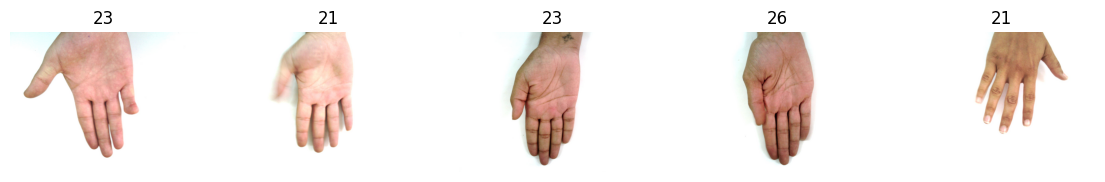

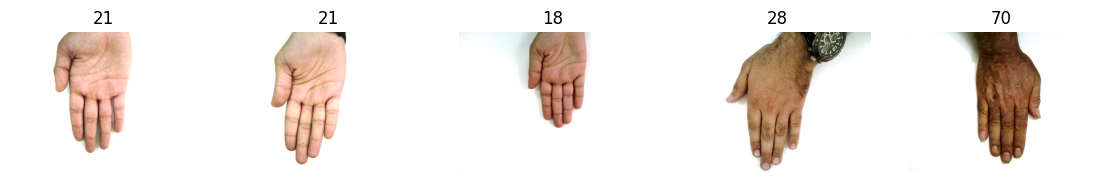

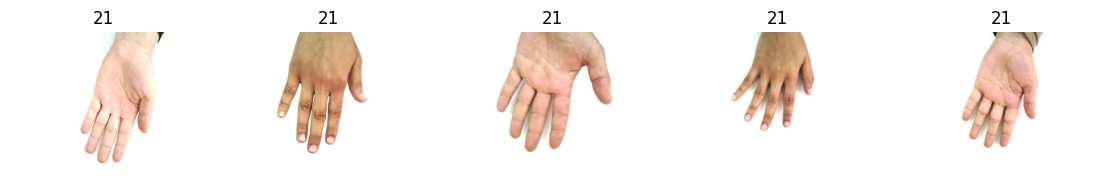

In [ ]:
# plot original dataset random images
plot_random_images(dataset_without_cropped, 5)
plot_random_images(dataset_without_cropped, 5)
plot_random_images(dataset_without_cropped, 5)

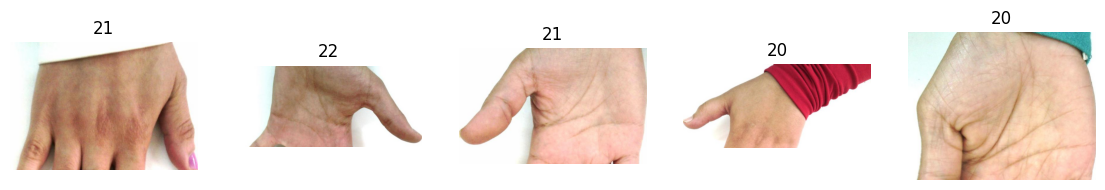

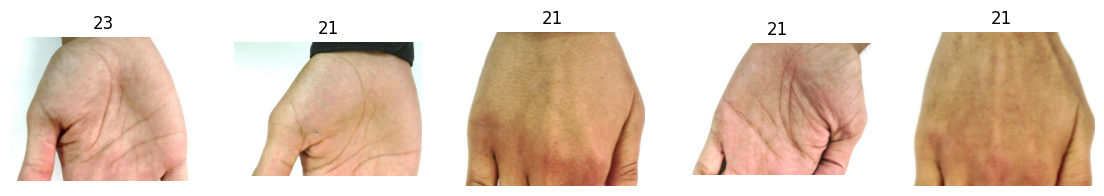

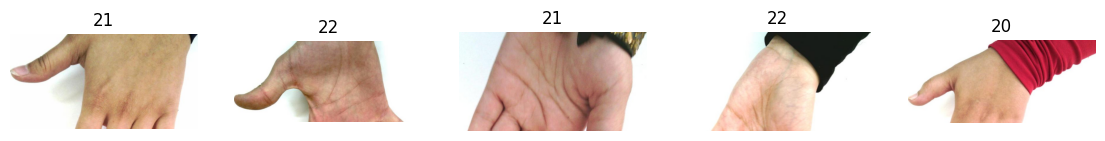

In [ ]:
# plot cropped dataset random images
plot_random_images(dataset_new, 5)
plot_random_images(dataset_new, 5)
plot_random_images(dataset_new, 5)

In [ ]:
# check distribution of age
class_counts = df_info['age'].value_counts()
total_classes = len(df_info)

class_percentages = (class_counts / total_classes) * 100

for class_name, count in class_counts.items():
    percentage = class_percentages[class_name]
    print(f"Class: {class_name}\t\t\t| Count: {count}\t\t| Percentage: {percentage:.2f}%")

Class: 21			| Count: 4930		| Percentage: 44.51%
Class: 22			| Count: 2434		| Percentage: 21.98%
Class: 20			| Count: 1935		| Percentage: 17.47%
Class: 23			| Count: 795		| Percentage: 7.18%
Class: 27			| Count: 133		| Percentage: 1.20%
Class: 26			| Count: 124		| Percentage: 1.12%
Class: 24			| Count: 97		| Percentage: 0.88%
Class: 70			| Count: 84		| Percentage: 0.76%
Class: 75			| Count: 83		| Percentage: 0.75%
Class: 25			| Count: 81		| Percentage: 0.73%
Class: 19			| Count: 78		| Percentage: 0.70%
Class: 28			| Count: 63		| Percentage: 0.57%
Class: 54			| Count: 52		| Percentage: 0.47%
Class: 18			| Count: 48		| Percentage: 0.43%
Class: 43			| Count: 46		| Percentage: 0.42%
Class: 29			| Count: 40		| Percentage: 0.36%
Class: 36			| Count: 28		| Percentage: 0.25%
Class: 30			| Count: 25		| Percentage: 0.23%


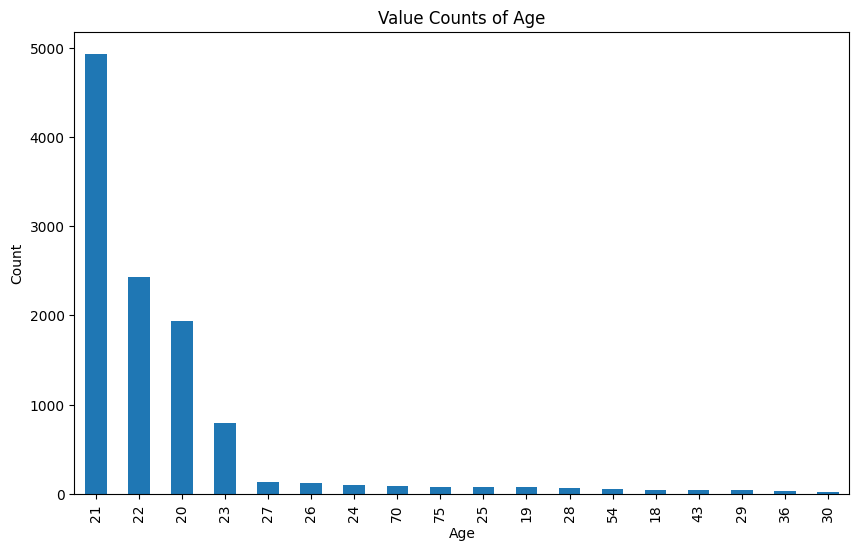

In [ ]:
# visualize the distribution
age_value_counts = df_info['age'].value_counts()
plt.figure(figsize=(10, 6))
age_value_counts.plot(kind='bar')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Value Counts of Age')
plt.show()

In [ ]:
dataset_new['age'].value_counts()

21    4930
22    2434
20    1935
23     795
27     133
26     124
24      97
70      84
75      83
25      81
19      78
28      63
54      52
18      48
43      46
29      40
36      28
30      25
Name: age, dtype: int64

In [ ]:
# improt the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
!pip install tabulate
from tabulate import tabulate
import os
import matplotlib.image as mpimg
import random
import cv2

pd.set_option('display.max_columns', None)

# Ignore warning
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df_info = pd.read_csv("/content/HandInfo.csv")
df_info.head()

,id,age,gender,skinColor,accessories,nailPolish,aspectOfHand,imageName,irregularities
0,0,27,male,fair,0,0,dorsal right,Hand_0000002.jpg,0
1,0,27,male,fair,0,0,dorsal right,Hand_0000003.jpg,0
2,0,27,male,fair,0,0,dorsal right,Hand_0000004.jpg,0
3,0,27,male,fair,0,0,dorsal right,Hand_0000005.jpg,0
4,0,27,male,fair,0,0,dorsal right,Hand_0000006.jpg,0


In [ ]:
def create_dataframe_from_images(image_folder_path):
    image_paths = []

    # Count total files to set up tqdm
    total_files = sum(len(files) for _, _, files in os.walk(image_folder_path))

    with tqdm(total=total_files, desc="Processing images") as pbar:
        for root, dirs, files in os.walk(image_folder_path):
            for file in files:
                if file.endswith(".jpg") or file.endswith(".jpeg"):
                    image_paths.append(os.path.join(root, file))
                    pbar.update(1)

    data = {'Image_Path': image_paths}
    df = pd.DataFrame(data)
    return df

In [ ]:
folder_path = '/content/drive/MyDrive/Hands Dataset/Cropped Dataset'
dataset1 = create_dataframe_from_images(folder_path)
dataset1.head()

Processing images:   0%|          | 0/11076 [00:00<?, ?it/s]

,Image_Path
0,/content/drive/MyDrive/Hands Dataset/Cropped D...
1,/content/drive/MyDrive/Hands Dataset/Cropped D...
2,/content/drive/MyDrive/Hands Dataset/Cropped D...
3,/content/drive/MyDrive/Hands Dataset/Cropped D...
4,/content/drive/MyDrive/Hands Dataset/Cropped D...


In [ ]:
df_info['age'].unique().tolist()

[27, 20, 21, 22, 26, 23, 30, 29, 43, 36, 25, 54, 70, 75, 19, 18, 24, 28]

In [ ]:
import os

parent_dir = "/content/drive/MyDrive/Hands Dataset/Dataset"
augmented_dir_name = "Augmented"

# Create the parent directory if it doesn't exist
if not os.path.exists(parent_dir):
    os.mkdir(parent_dir)

# Get unique ages
ages = df_info['age'].unique().tolist()

for age in ages:
    age_dir = os.path.join(parent_dir, str(age))
    if not os.path.exists(age_dir):
        os.mkdir(age_dir)
    else:
        print(f"Directory '{age_dir}' already exists.")

    # Create the augmented directory within each age directory
    augmented_dir = os.path.join(age_dir, augmented_dir_name)
    if not os.path.exists(augmented_dir):
        os.mkdir(augmented_dir)
    else:
        print(f"Directory '{augmented_dir}' already exists.")

Directory '/content/drive/MyDrive/Hands Dataset/Dataset/27' already exists.
Directory '/content/drive/MyDrive/Hands Dataset/Dataset/20' already exists.
Directory '/content/drive/MyDrive/Hands Dataset/Dataset/20/Augmented' already exists.
Directory '/content/drive/MyDrive/Hands Dataset/Dataset/21' already exists.
Directory '/content/drive/MyDrive/Hands Dataset/Dataset/21/Augmented' already exists.
Directory '/content/drive/MyDrive/Hands Dataset/Dataset/22' already exists.
Directory '/content/drive/MyDrive/Hands Dataset/Dataset/22/Augmented' already exists.
Directory '/content/drive/MyDrive/Hands Dataset/Dataset/26' already exists.
Directory '/content/drive/MyDrive/Hands Dataset/Dataset/23' already exists.
Directory '/content/drive/MyDrive/Hands Dataset/Dataset/30' already exists.
Directory '/content/drive/MyDrive/Hands Dataset/Dataset/29' already exists.
Directory '/content/drive/MyDrive/Hands Dataset/Dataset/43' already exists.
Directory '/content/drive/MyDrive/Hands Dataset/Dataset/36

In [ ]:
def concatenate_info_data(dataset1, df_info_copy):
  dataset1['imageName'] = dataset1['Image_Path'].apply(lambda x:x.split("/")[-1])
  dataset_new = dataset1.merge(df_info_copy, on='imageName')
  return dataset_new

In [ ]:
df_info_copy = df_info.copy()
df_info_copy = df_info_copy[['imageName','age', 'aspectOfHand']]
df_info_copy.head()

,imageName,age,aspectOfHand
0,Hand_0000002.jpg,27,dorsal right
1,Hand_0000003.jpg,27,dorsal right
2,Hand_0000004.jpg,27,dorsal right
3,Hand_0000005.jpg,27,dorsal right
4,Hand_0000006.jpg,27,dorsal right


In [ ]:
dataset_new = concatenate_info_data(dataset1, df_info_copy)
dataset_new.head()

,Image_Path,imageName,age,aspectOfHand
0,/content/drive/MyDrive/Hands Dataset/Cropped D...,Hand_0008820.jpg,20,palmar right
1,/content/drive/MyDrive/Hands Dataset/Cropped D...,Hand_0011076.jpg,22,dorsal left
2,/content/drive/MyDrive/Hands Dataset/Cropped D...,Hand_0000314.jpg,21,dorsal right
3,/content/drive/MyDrive/Hands Dataset/Cropped D...,Hand_0007944.jpg,21,dorsal right
4,/content/drive/MyDrive/Hands Dataset/Cropped D...,Hand_0004989.jpg,21,palmar right


In [ ]:
dataset_new[dataset_new['age'] == 20]

,Image_Path,imageName,age,aspectOfHand
0,/content/drive/MyDrive/Hands Dataset/Cropped D...,Hand_0008820.jpg,20,palmar right
12,/content/drive/MyDrive/Hands Dataset/Cropped D...,Hand_0002934.jpg,20,palmar right
13,/content/drive/MyDrive/Hands Dataset/Cropped D...,Hand_0002407.jpg,20,dorsal left
23,/content/drive/MyDrive/Hands Dataset/Cropped D...,Hand_0002329.jpg,20,dorsal right
24,/content/drive/MyDrive/Hands Dataset/Cropped D...,Hand_0005654.jpg,20,dorsal left
...,...,...,...,...
11049,/content/drive/MyDrive/Hands Dataset/Cropped D...,Hand_0001351.jpg,20,dorsal right
11055,/content/drive/MyDrive/Hands Dataset/Cropped D...,Hand_0003216.jpg,20,dorsal right
11062,/content/drive/MyDrive/Hands Dataset/Cropped D...,Hand_0004584.jpg,20,palmar right
11072,/content/drive/MyDrive/Hands Dataset/Cropped D...,Hand_0008793.jpg,20,dorsal right


In [ ]:
import shutil

source_dir = "/content/drive/MyDrive/Hands Dataset/Cropped Dataset"

def copying_files(source_dir):
  for age in tqdm(dataset_new['age'].unique(), desc='Copying images'):
      dataset_age = dataset_new[dataset_new['age'] == age]

      destination_dir = f"/content/drive/MyDrive/Hands Dataset/Dataset/{age}"

      # Copy files from source directory to destination directory
      for index, row in dataset_age.iterrows():
          source_file = row['Image_Path']
          image_name = row['imageName']
          destination_file = os.path.join(destination_dir, image_name)
          # Copy the file
          shutil.copy(source_file, destination_file)

# copying_files(source_dir)

Copying images:   0%|          | 0/18 [00:00<?, ?it/s]

In [ ]:
folder_path = '/content/drive/MyDrive/Hands Dataset/Dataset'
dataset1 = create_dataframe_from_images(folder_path)
dataset1.head()

Processing images:   0%|          | 0/11076 [00:00<?, ?it/s]

,Image_Path
0,/content/drive/MyDrive/Hands Dataset/Dataset/2...
1,/content/drive/MyDrive/Hands Dataset/Dataset/2...
2,/content/drive/MyDrive/Hands Dataset/Dataset/2...
3,/content/drive/MyDrive/Hands Dataset/Dataset/2...
4,/content/drive/MyDrive/Hands Dataset/Dataset/2...


In [ ]:
dataset1.shape

(11076, 1)

In [ ]:
dataset1['age'] = dataset1['Image_Path'].apply(lambda x: x.split("/")[-2]).astype(int)
dataset1.head()

,Image_Path,age
0,/content/drive/MyDrive/Hands Dataset/Dataset/2...,27
1,/content/drive/MyDrive/Hands Dataset/Dataset/2...,27
2,/content/drive/MyDrive/Hands Dataset/Dataset/2...,27
3,/content/drive/MyDrive/Hands Dataset/Dataset/2...,27
4,/content/drive/MyDrive/Hands Dataset/Dataset/2...,27


In [ ]:
dataset1.shape

(11076, 2)

In [ ]:
df_info_copy['age'].value_counts()

age
21    4930
22    2434
20    1935
23     795
27     133
26     124
24      97
70      84
75      83
25      81
19      78
28      63
54      52
18      48
43      46
29      40
36      28
30      25
Name: count, dtype: int64

In [ ]:
def get_minority_ages(df, min_count=700):
    age_counts = df['age'].value_counts()
    ages_less_than_min_count = age_counts[age_counts < min_count].index.tolist()
    print("Total Minority Ages:", len(ages_less_than_min_count))
    print("")
    print("Ages with counts less than", min_count, ":")
    print(ages_less_than_min_count)
    return ages_less_than_min_count

In [ ]:
minority_ages = get_minority_ages(df_info_copy, min_count=1000)

Total Minority Ages: 15

Ages with counts less than 1000 :
[23, 27, 26, 24, 70, 75, 25, 19, 28, 54, 18, 43, 29, 36, 30]


In [ ]:
dataset1['Image_Path'][0]

'/content/drive/MyDrive/Hands Dataset/Dataset/27/Hand_0009975.jpg'

# <font color='magma' size=6>**Data Augmentation**

____________
Data augmentation was then used on the partials to enhance the diversity and size of a dataset by applying various transformations to the original data. Three types of image transformations were employed:
•	Horizontal flipping – This transformation is implement-ed using the “Fliplr” method from the Python Imaging library. It horizontally flips images with a probability randomly chosen from the specified range (0.5 to 1.0). Here the probability of 0.5 means that there is a 50% chance that an image will be flipped horizontally.
•	Rotation – The “Affine” method is used to rotate images by a specified range of degrees. Here the images can be rotated clockwise or counterclockwise within the range of -20 to 20 degrees. This parameter controls the extent of rotation applied to the images.
•	Gaussian Blur – Gaussian blur is applied using the “GaussianBlur” method. It smoothens the images by av-eraging the pixel values within a neighbourhood defined by the standard deviation (sigma). The sigma parameter is randomly chosen from the specified range of 0 to 1.0, controlling the amount of blur applied to the images.
By combining these all three augmentation techniques, we introduce approximately 3000 variability into the da-taset, which helps to improve the model’s performance and generalization ability. The ranges specified for each parame-ter allow for flexibility in the augmentation process, ena-bling the generation of a diverse set of augmented images while preserving the original dataset’s characteristics


In [ ]:
!pip install imgaug

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 35.3 MB/s eta 0:00:00


In [ ]:
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [ ]:
def augment_and_plot(image_path, augmentation_params, num_images=5):
    original_image = Image.open(image_path)

    # Define augmentation sequence
    seq = iaa.Sequential(augmentation_params)

    # plot
    fig, axs = plt.subplots(1, num_images, figsize=(20, 5))
    for i in range(num_images):
        augmented_image = seq(image=np.array(original_image))
        axs[i].imshow(augmented_image)
        axs[i].set_title("Augmented Image " + str(i+1)) 
        axs[i].axis("off")

    plt.show()

In [ ]:
def define_augmentation_params(flip_prob_range=(0.5, 1.0), rotation_range=(-20, 20), blur_sigma_range=(0, 1.0)):
    augmentation_params = [
        iaa.Fliplr(p=np.random.uniform(*flip_prob_range)),  # horizontally flip images with random probability between specified range
        iaa.Affine(rotate=rotation_range),  # rotate images by specified degrees
        iaa.GaussianBlur(sigma=blur_sigma_range)  # apply gaussian blur with specified sigma range
    ]
    return augmentation_params

In [ ]:
augmentation_params = define_augmentation_params()

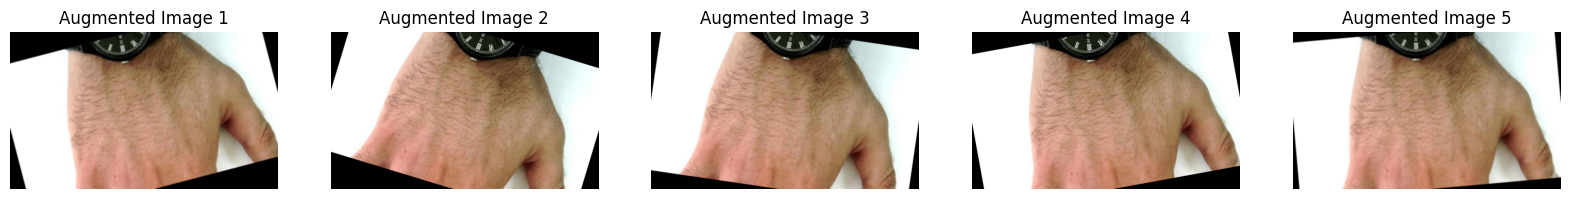

In [ ]:
original_image_path = "/content/drive/MyDrive/Hands Dataset/Dataset/27/Hand_0009975.jpg"
augment_and_plot(original_image_path, augmentation_params)

In [ ]:
import random

def augment_image(image_path, augmentation_params):
    original_image = Image.open(image_path)
    seq = iaa.Sequential(augmentation_params)
    augmented_images = seq(images=[np.array(original_image) for _ in range(1)])
    return augmented_images

In [ ]:
from PIL import Image

def generate_and_save_augment_images(parent_dir, dataset, minority_ages, target_augmented_images, augmentation_params):
    # Iterate over minority ages
    for age in tqdm(minority_ages, desc="Generating Augmented Images"):
        age_dir = os.path.join(parent_dir, str(age))
        augmented_dir = os.path.join(age_dir, "Augmented")
        if not os.path.exists(augmented_dir):
            os.mkdir(augmented_dir)
        dataset_age = dataset[dataset['age'] == age]
        augmented_image_count = 0  # Track the number of augmented images
        for _ in tqdm(range(target_augmented_images), desc=f'Generating Images - {age}'):  # Select a random image 'target_augmented_images' times
            random_row = random.choice(dataset_age.index)
            image_path = dataset_age.loc[random_row, 'Image_Path']
            augmented_images = augment_image(image_path, augmentation_params)
            for i, img_array in enumerate(augmented_images):
                img = Image.fromarray(img_array)
                augmented_image_name = f"{os.path.basename(image_path).split('.')[0]}_aug_{random.randint(1, 9999999)}.jpg"
                augmented_image_path = os.path.join(augmented_dir, augmented_image_name)
                img.save(augmented_image_path)
                augmented_image_count += 1


In [ ]:
parent_dir = "/content/drive/MyDrive/Hands Dataset/Dataset"

# Get minority ages
minority_ages = get_minority_ages(df_info_copy, min_count=1000)

# Define the target number of augmented images
target_augmented_images = 795

# Define augmentation parameters
augmentation_params = define_augmentation_params()

Total Minority Ages: 15

Ages with counts less than 1000 :
[23, 27, 26, 24, 70, 75, 25, 19, 28, 54, 18, 43, 29, 36, 30]


In [ ]:
# generate and save augmented images
generate_and_save_augment_images(parent_dir, dataset1, minority_ages, target_augmented_images, augmentation_params)

Generating Augmented Images:   0%|          | 0/15 [00:00<?, ?it/s]

Generating Images - 23:   0%|          | 0/1300 [00:00<?, ?it/s]

Generating Images - 27:   0%|          | 0/1300 [00:00<?, ?it/s]

Generating Images - 26:   0%|          | 0/1300 [00:00<?, ?it/s]

Generating Images - 24:   0%|          | 0/1300 [00:00<?, ?it/s]

Generating Images - 70:   0%|          | 0/1300 [00:00<?, ?it/s]

Generating Images - 75:   0%|          | 0/1300 [00:00<?, ?it/s]

Generating Images - 25:   0%|          | 0/1300 [00:00<?, ?it/s]

Generating Images - 19:   0%|          | 0/1300 [00:00<?, ?it/s]

Generating Images - 28:   0%|          | 0/1300 [00:00<?, ?it/s]

Generating Images - 54:   0%|          | 0/1300 [00:00<?, ?it/s]

Generating Images - 18:   0%|          | 0/1300 [00:00<?, ?it/s]

Generating Images - 43:   0%|          | 0/1300 [00:00<?, ?it/s]

Generating Images - 29:   0%|          | 0/1300 [00:00<?, ?it/s]

Generating Images - 36:   0%|          | 0/1300 [00:00<?, ?it/s]

Generating Images - 30:   0%|          | 0/1300 [00:00<?, ?it/s]

# <font color='magma'> **Balance Dataset**

* To identify the ages with a sufficient number of individuals, we computed the count of unique individuals for each age group in the dataset. This count provided insight into the distribution of individuals across different ages. We then filtered this information to retain only those age groups where the count of individuals was two or more. These age groups were considered to have adequate representation in the dataset.

* The selected age groups with sufficient data were as follows: **[19, 20, 21, 22, 23, 24, 25, 26**]. Each of these age groups had at least two individuals present in the dataset.

* Subsequently, to balance the dataset, we aimed to ensure an equal contribution of samples from each selected age group. This involved sampling a fixed number of samples from each age group, set to match the count of samples present in the age group with the fewest individuals. As a result, each age group contributed **795** images to the final balanced dataset.

* This balancing strategy ensured that each age group was equally represented in the dataset, thereby minimizing potential biases related to age-related features during subsequent model training and evaluation processes.

In [ ]:
# improt the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
!pip install tabulate
from tabulate import tabulate
import os
import matplotlib.image as mpimg
import random
import cv2

pd.set_option('display.max_columns', None)

# Ignore warning
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def create_dataframe_from_images(image_folder_path):
    image_paths = []

    # Count total files to set up tqdm
    total_files = sum(len(files) for _, _, files in os.walk(image_folder_path))

    with tqdm(total=total_files, desc="Processing images") as pbar:
        for root, dirs, files in os.walk(image_folder_path):
            for file in files:
                if file.endswith(".jpg") or file.endswith(".jpeg"):
                    image_paths.append(os.path.join(root, file))
                    pbar.update(1)

    data = {'Image_Path': image_paths}
    df = pd.DataFrame(data)
    return df

In [ ]:
folder_path = '/content/drive/MyDrive/Hands Dataset/Dataset'
dataset = create_dataframe_from_images(folder_path)
dataset.head()

Processing images:   0%|          | 0/30576 [00:00<?, ?it/s]

,Image_Path
0,/content/drive/MyDrive/Hands Dataset/Dataset/2...
1,/content/drive/MyDrive/Hands Dataset/Dataset/2...
2,/content/drive/MyDrive/Hands Dataset/Dataset/2...
3,/content/drive/MyDrive/Hands Dataset/Dataset/2...
4,/content/drive/MyDrive/Hands Dataset/Dataset/2...


In [ ]:
dataset.shape

(30576, 1)

In [ ]:
dataset['Image_Path'] = dataset['Image_Path'].apply(lambda x: x.replace("/Augmented", ""))

In [ ]:
dataset['age'] = dataset['Image_Path'].apply(lambda x: x.split("/")[-2]).astype(int)
dataset.head()

,Image_Path,age
0,/content/drive/MyDrive/Hands Dataset/Dataset/2...,27
1,/content/drive/MyDrive/Hands Dataset/Dataset/2...,27
2,/content/drive/MyDrive/Hands Dataset/Dataset/2...,27
3,/content/drive/MyDrive/Hands Dataset/Dataset/2...,27
4,/content/drive/MyDrive/Hands Dataset/Dataset/2...,27


In [ ]:
dataset['age'].value_counts()

age
21    4930
22    2434
23    2095
20    1935
27    1433
26    1424
24    1397
70    1384
75    1383
25    1381
19    1378
28    1363
54    1352
18    1348
43    1346
29    1340
36    1328
30    1325
Name: count, dtype: int64

In [ ]:
df_info = pd.read_csv("/content/drive/MyDrive/Hands Dataset/HandInfo.csv")
df_info.head()

,id,age,gender,skinColor,accessories,nailPolish,aspectOfHand,imageName,irregularities
0,0,27,male,fair,0,0,dorsal right,Hand_0000002.jpg,0
1,0,27,male,fair,0,0,dorsal right,Hand_0000003.jpg,0
2,0,27,male,fair,0,0,dorsal right,Hand_0000004.jpg,0
3,0,27,male,fair,0,0,dorsal right,Hand_0000005.jpg,0
4,0,27,male,fair,0,0,dorsal right,Hand_0000006.jpg,0


In [ ]:
# check number of persons per age
df_no_person_per_age = df_info.groupby('age')['id'].nunique().to_frame().reset_index().rename(columns={'id': 'no_person_per_age'})
df_no_person_per_age

,age,no_person_per_age
0,18,1
1,19,2
2,20,39
3,21,80
4,22,36
5,23,16
6,24,2
7,25,2
8,26,2
9,27,1


In [ ]:
def check_distribution(dataset):
  # Distribution of Age
  plt.figure(figsize=(15, 6))
  sns.countplot(data=dataset, x='age', palette='Set3')
  plt.title('Count Plot by Age')
  plt.xlabel('Age')
  plt.ylabel('Count')

  ax = plt.gca()
  for p in ax.patches:
      ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

  plt.show()

In [ ]:
# Filter the DataFrame to get ages where the number of people per age is >= 2
grouped_ages = df_no_person_per_age[df_no_person_per_age['no_person_per_age'] >= 2]['age'].values.tolist()

# Display the list of ages
print(grouped_ages)


[19, 20, 21, 22, 23, 24, 25, 26]


In [ ]:
dataset_new = dataset[dataset['age'].isin(grouped_ages)]
dataset_new['age'].value_counts()

age
21    4930
22    2434
23    2095
20    1935
26    1424
24    1397
25    1381
19    1378
Name: count, dtype: int64

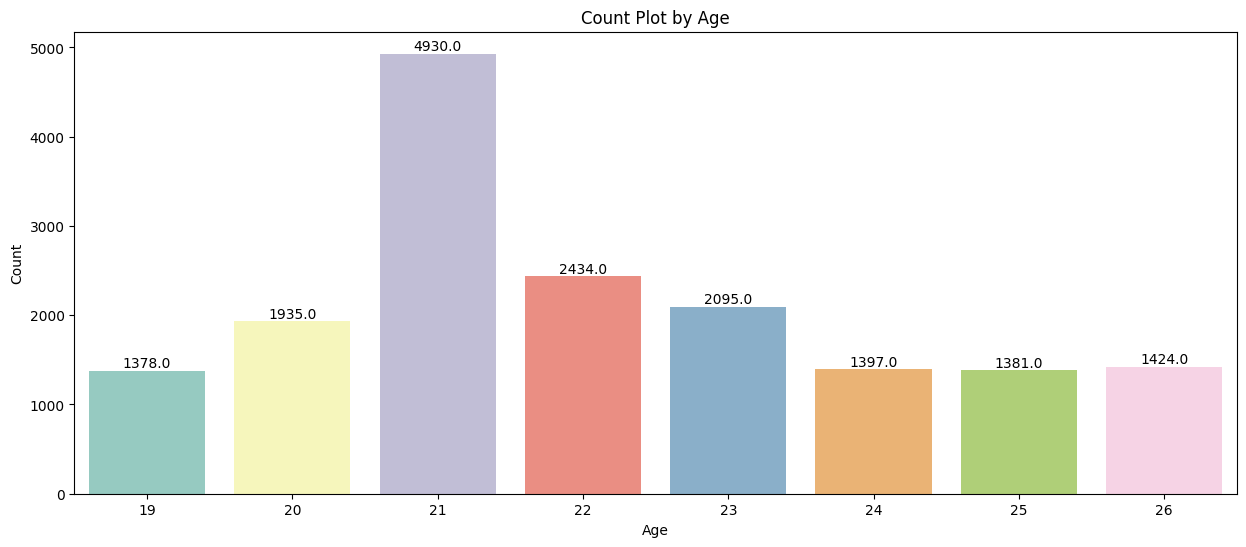

In [ ]:
check_distribution(dataset_new)

In [ ]:
grouped_dataset = dataset_new.groupby('age').apply(lambda x: x.sample(n=795, random_state=42))
grouped_dataset = grouped_dataset.reset_index(drop=True)
grouped_dataset.head()

,Image_Path,age
0,/content/drive/MyDrive/Hands Dataset/Dataset/1...,19
1,/content/drive/MyDrive/Hands Dataset/Dataset/1...,19
2,/content/drive/MyDrive/Hands Dataset/Dataset/1...,19
3,/content/drive/MyDrive/Hands Dataset/Dataset/1...,19
4,/content/drive/MyDrive/Hands Dataset/Dataset/1...,19


In [ ]:
grouped_dataset['age'].value_counts()

age
19    795
20    795
21    795
22    795
23    795
24    795
25    795
26    795
Name: count, dtype: int64

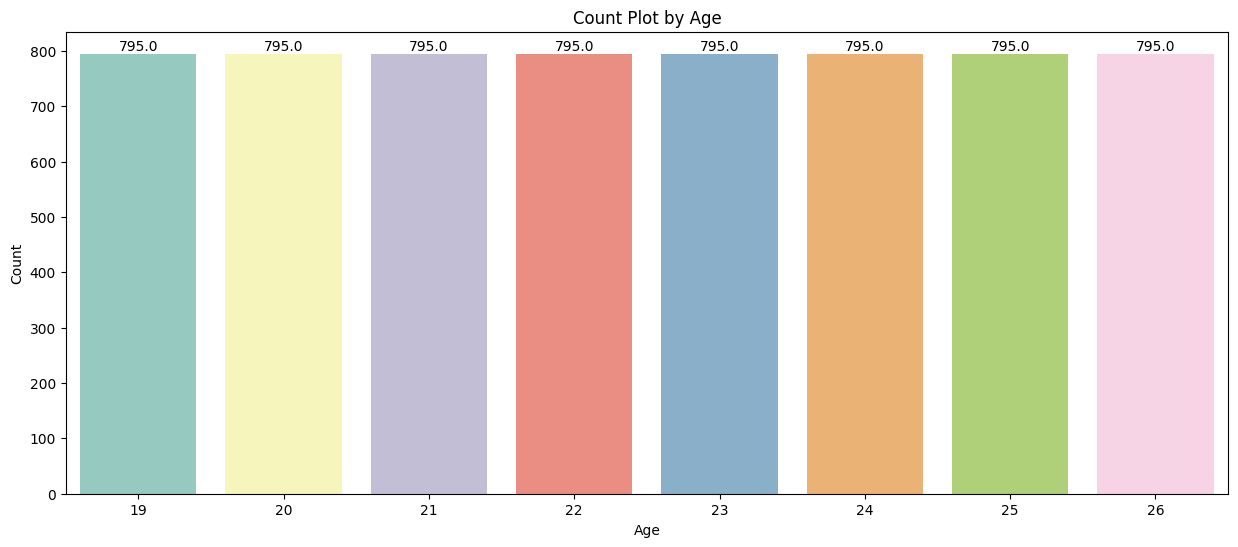

In [ ]:
check_distribution(grouped_dataset)

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import imgaug
import cv2
import sklearn
import tensorflow as tf
import keras
import sys

# Print version of Python
print("Python version:", sys.version)

# Print version of Pandas
print("Pandas version:", pd.__version__)

# Print version of NumPy
print("NumPy version:", np.__version__)

# Print version of Matplotlib
print("Matplotlib version:", matplotlib.__version__)

# Print version of Seaborn
print("Seaborn version:", sns.__version__)

# Print version of imgaug
print("imgaug version:", imgaug.__version__)

# Print version of OpenCV
print("OpenCV version:", cv2.__version__)

# Print version of scikit-learn (sklearn)
print("scikit-learn version:", sklearn.__version__)

# Print version of TensorFlow
print("TensorFlow version:", tf.__version__)

# Print version of Keras
print("Keras version:", keras.__version__)

Python version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
Pandas version: 2.0.3
NumPy version: 1.25.2
Matplotlib version: 3.7.1
Seaborn version: 0.13.1
imgaug version: 0.4.0
OpenCV version: 4.8.0
scikit-learn version: 1.2.2
TensorFlow version: 2.15.0
Keras version: 2.15.0
